# Naïve Bayes

## Introduction
### About Naïve Bayes

Naive Bayes classifier is a supervised machine learning algorithm and seeks to model the distribution of inputs of a given class or category. It is widely used for classification tasks, especially in natural language processing and text analysis, spam filtering, etc. 
Naive Bayes is based on the Bayes Theorem, which calculates the probability of a hypothesis (class label) given some observed evidence
(features). Mathematically, Bayes' theorem is represented as:

$$
P(Class|Features) = \frac{P(Features|Class)*P(Class)}{P(Features)}
$$

__Objectives__: We would like to divide my 'Wild Life' dataset into train and test dataset, and see how much accuracy the Naive Bayes model will give us. By using the 'IUCN' column as a lable, we would want to see how much the model will get the test data right. 

__Acheivements__: We would like to acheive the accuracy of the model via using the Naive Bayes classification, and see how accurate the Naive Bayes model is. 

### Types of Naïve Bayes Classifier
__1. Gaussian Naive Bayes__
   
   Gaussian Naive Bayes is used when the variable is continuous variable. This model is suitable for data such as measurements, where the value follows a normal distribution. 

__2. Multinomial Naive Bayes__

   This model runs for varibles that are bigger than 2, more options other than 0 and 1, and it is often used in text classification where the features are word counts. We use `MultinomialNB` object and this implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification.

__3. Bernoulli Naive Bayes__

   This model runs when the variables hold 0 and 1. We use `BernoulliNB` object for this case, and this might perform better on some datasets, especially those with shorter documents. It is advisable to evaluate both models, if time permits.

## Prepare Data for Naïve Bayes

1. Record Data: Wild Life dataset
2. Text Data: Data retrieved via Wikipedia API

In [99]:
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn 
import itertools
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

### 1. Record Data: Wild Life Dataset

In [100]:
wildlife = pd.read_csv('./data/wild_life_cleaned.csv')
df = wildlife[['IUCN','Species','Country','Value']]

### 2. Text Data: Data retrieved via News API

In [112]:
# load the text data
textdata = pd.read_csv('./data/wiki_textdata.csv')

textdata.head()

,text,label,sentiment
0,pursuant eagle feather law title 50 part 22 co...,Wildlife,0.9670
1,founding 1896 work division biological survey ...,Wildlife,0.9468
2,edward goldman survey made perfectly clear pos...,Wildlife,-0.9313
3,1940 1970 fws 1956 usfws operated fleet seagoi...,Wildlife,0.0000
4,upon creation 1940 fws inherited bof fleet bro...,Wildlife,0.6369


In [113]:
def categorize_sentiment(value):
    if value >= 0.5:
        return 'positive'
    elif value < 0.5 and value >= 0:
        return 'neutral'
    else:
        return 'negative'

textdata = textdata[['text', 'sentiment']]
textdata['sentiment'] = textdata['sentiment'].apply(lambda x: categorize_sentiment(x))

textdata.head()

,text,sentiment
0,pursuant eagle feather law title 50 part 22 co...,positive
1,founding 1896 work division biological survey ...,positive
2,edward goldman survey made perfectly clear pos...,negative
3,1940 1970 fws 1956 usfws operated fleet seagoi...,neutral
4,upon creation 1940 fws inherited bof fleet bro...,positive


In [114]:
train_data, test_data = train_test_split(textdata, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_data.head()

,text,sentiment
80,least one wildlife refuge every state national...,positive
464,wind solar power production consistently match...,positive
346,climate change doubter bob inglis former repre...,negative
627,jepsen henrik et al negotiating paris agreemen...,positive
371,cop negotiation resumed 17 27 july 2001 bonn g...,positive


## Feature Selection

In [60]:
# This function computes the figure of merit given a subset of features
# it works for both the Pearson and Spearman correlation matrix

def merit(x, y, correlation='pearson'):
    k = x.shape[1]
    
    if correlation == 'pearson':
        rho_xx = np.mean(np.corrcoef(x, x, rowvar = False))
        rho_xy = np.mean(np.corrcoef(x, y, rowvar = False))
    elif correlation == 'spearman':
        rho_xx = np.mean(spearmanr(x, x, axis = 0)[0])
        rho_xy = np.mean(spearmanr(x, y, axis = 0)[0])
    else:
        raise ValueError("Error: Unsupported Correlation Method. Try Again.")
    
    merit_numerator = k * np.absolute(rho_xy)
    merit_denominator = np.sqrt(k + k * (k - 1) * np.absolute(rho_xx))
    merit_score = merit_numerator / merit_denominator
    
    return merit_score


# this function takes two matrices x and y, iterates over all possible subset combinations of the x features, 
# and computes the figure of merit for each subset. 
# It keeps track of the max merit and returns the optimal subset at the end
def maximize_CFS(x, y):
    num_features = x.shape[1]
    max_merit = 0
    optimal_subset = None
    list1 = [*range(0, num_features)]
    for L in range(1, len(list1) + 1):
        for subset in itertools.combinations(list1, L):
            x_subset = x[:, list(subset)]
            subset_merit = merit(x_subset, y)
            if subset_merit > max_merit:
                max_merit = subset_merit
                optimal_subset = list(subset)
    return optimal_subset  # return the indices of selected features

### Feature Selection for Record Data

In [61]:
df_rec = wildlife.loc[(wildlife['Species'] == 'Mammals') | (wildlife['Species'] == 'Birds') | (wildlife['Species'] == 'Reptiles') & (wildlife['IUCN'] == 'THREATENED')].reset_index(drop=True)

In [62]:
df_rec['Reptiles'] = (df_rec['Species'] == 'Reptiles').astype(int)
df_rec['Mammals'] = (df_rec['Species'] == 'Mammals').astype(int)
df_rec['Birds'] = (df_rec['Species'] == 'Birds').astype(int)

In [63]:
# convert dataframes to numpy arrays
x = df_rec[['Reptiles', 'Mammals', 'Birds']].values
x = np.nan_to_num(x, nan=0)
y = df_rec[['Value']].values

selected_indices = maximize_CFS(x, y)
print(selected_indices)

[2]


An output of [2] in the above code indicates that, according to the Correlation-based Feature Selection (CFS) algorithm, the optimal subset comprises only the `Birds` feature. This suggests that, under the criteria applied, 'Birds' provides the most valuable information for classifying the 'Value' variable.

In [64]:
z1 = df_rec['Birds'].values
z1 = np.nan_to_num(x, nan=0)

merit(z1,y)

0.11914801353106631

'Mammals' and 'Reptiles' are considered less informative for predicting 'Value' using this particular feature selection approach and correlation-based merit score.

Additionally, a merit score of 0.119 indicates a positive correlation between the 'Birds' feature and 'Value,' indicating that ‘Birds’ contains relevant information for predicting the target variable.

### Feature Selection for Text Data

In [115]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Define features and target variable 
X_train = train_data['text'].tolist()
y_train = train_data['sentiment']

In [116]:
# map the lables
label_mapping = {'neutral': 0, 'negative': -1, 'positive': 1}

y_train = y_train.map(label_mapping)

y_train.head()

80     1
464    1
346   -1
627    1
371    1
Name: sentiment, dtype: int64

In [117]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# initialize the CountVectorizer
vectorizer = CountVectorizer()

# fit and transform the text data
X_train_vectorized = vectorizer.fit_transform(X_train)

# convert text data to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)

# convert the vectorized training data into a dataframe
df = pd.DataFrame(X_train_vectorized.toarray())

df.describe()

,0,1,2,3,4,5,6,7,8,9,...,7431,7432,7433,7434,7435,7436,7437,7438,7439,7440
count,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,...,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000
mean,0.001637,0.106383,0.001637,0.001637,0.001637,0.001637,0.003273,0.001637,0.001637,0.001637,...,0.001637,0.001637,0.001637,0.019640,0.003273,0.026187,0.001637,0.001637,0.003273,0.001637
std,0.040456,0.540317,0.040456,0.040456,0.040456,0.040456,0.057166,0.040456,0.040456,0.040456,...,0.040456,0.040456,0.040456,0.180001,0.057166,0.423841,0.040456,0.040456,0.057166,0.040456
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,3.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000


In [118]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,7431,7432,7433,7434,7435,7436,7437,7438,7439,7440
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
# Since iterating every possible combination of subsets is time consuming, let's reduce the number of features
# let's calculate the sum of each column
column_sums = df.sum()

# find columns where the sum is 130 or less
columns_to_remove = column_sums[column_sums < 140].index

# remove the selected columns from the DataFrame
df = df.drop(columns=columns_to_remove)

df.head()

,595,765,1389,1490,1582,1934,2572,2622,3276,6375,6447,7043,7243,7409
0,0,0,0,1,1,0,0,1,0,2,1,0,0,0
1,0,0,0,1,0,0,0,4,0,0,0,0,0,0
2,0,0,0,5,10,0,0,1,1,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,4,3,0,0,0,3,3,0,0


The features has been reduced from approximately 14 columns to 5 columns. 

In [135]:
# the df got much smaller and more managable

#convert to arrays
x = df.values
y = y_train.values

optimal_subset_indices = maximize_CFS(x, y)

print(optimal_subset_indices)

[7]


In [136]:
x_opt = df.iloc[:, 7]
x_opt.head()

0    1
1    4
2    1
3    0
4    0
Name: 2622, dtype: int64

In [137]:
word_index = 2622 # the column index I want

vocabulary = vectorizer.vocabulary_

word = next(word for word, index in vocabulary.items() if index == word_index)

print("Word at column 2622:", word)

Word at column 2622: energy


## Naïve Bayes with Labeled Record Data

In [40]:
new_li = []

for item in df.IUCN.tolist():
    if item == 'THREATENED':
        new_li.append('THREATENED')
    elif (item == 'TOT_KNOWN') or (item == 'THREAT_PERCENT'):
        new_li.append(np.nan)
    else:
        new_li.append('OTHER')

In [41]:
df.IUCN = new_li

/var/folders/1z/6nvrnkz13ms1y39fh2328y7m0000gn/T/ipykernel_2209/2065111713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.IUCN = new_li


In [42]:
df = df.dropna().reset_index(drop = True)

In [43]:
df.IUCN = df.IUCN.astype('category')
df.Species = df.Species.astype('category')
df.Country = df.Country.astype('category')

In [44]:
from sklearn.preprocessing  import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')

encoded_data = encoder.fit_transform(df[['Species']])

# onvert the encoded data to a Pandas DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['Species']))

In [23]:
# see if the result is threatened if we put Species, Country, Value
df2 = pd.concat([df[['IUCN','Value']],encoded_df], axis =1, ignore_index= True)
df2.columns = ['IUCN','Value'] + encoder.get_feature_names_out(['Species']).tolist()
y = df2.IUCN
x = df2.drop(['IUCN'], axis = 1)

In [24]:
train_x, test_x, train_y, test_y = train_test_split(x,y)

In [25]:
model = GaussianNB()
# train
model.fit(train_x,train_y) 

predicted = model.predict(test_x) 
res = pd.DataFrame({'predicted': predicted, 'actual': test_y}).reset_index(drop = True)

In [26]:
xx = 0

for i in range(res.shape[0]):
    if res.predicted[i] == res.actual[i]:
        xx += 1
    else: pass

print(f'The accuracy rate for NB is: {round(xx/res.shape[0],2)}') # divide to the size of test

The accuracy rate for NB is: 0.72


### Confusion Matrix for Record Data

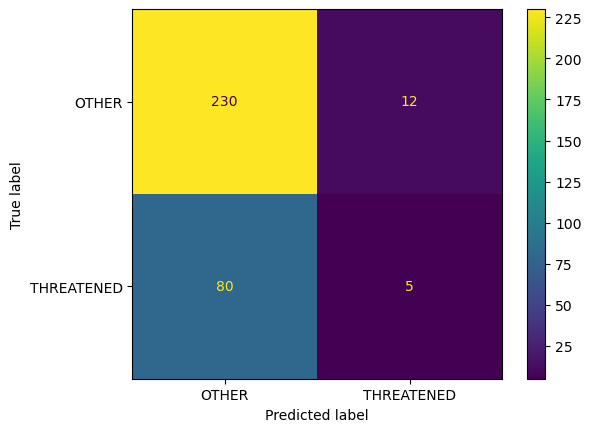

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(res.actual.tolist(), res.predicted.tolist(), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= model.classes_)
disp.plot()

In [28]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(test_y, res.predicted)
report = classification_report(test_y, res.predicted)

print(f'Accuracy: {accuracy}')
print(report)

Accuracy: 0.7186544342507645
              precision    recall  f1-score   support

       OTHER       0.74      0.95      0.83       242
  THREATENED       0.29      0.06      0.10        85

    accuracy                           0.72       327
   macro avg       0.52      0.50      0.47       327
weighted avg       0.63      0.72      0.64       327



## Naïve Bayes with Labeled Text Data

In [138]:
test_data.head()

,text,sentiment
512,human ecosystem vulnerability interdependent 1...,negative
357,plan compiled made part bali action plan un ra...,neutral
110,christopher columbus began exploring caribbean...,negative
684,2007 harris interactive surveyed 489 randomly ...,negative
39,kuno wildlife sanctuary established 1981 initi...,neutral


In [139]:
# let's separate our feature(s) from our target variable
X_test = test_data['text']
y_test = test_data['sentiment']
X_test.head()

512    human ecosystem vulnerability interdependent 1...
357    plan compiled made part bali action plan un ra...
110    christopher columbus began exploring caribbean...
684    2007 harris interactive surveyed 489 randomly ...
39     kuno wildlife sanctuary established 1981 initi...
Name: text, dtype: object

In [144]:
# create a new column 'energy_count'
X_test_energy = X_test.str.lower().str.count('energy')
X_test_energy.head()

512    0
357    0
110    0
684    0
39     0
Name: text, dtype: int64

In [145]:
# Define a dictionary to map labels to numeric values
label_mapping = {'neutral': 0, 'negative': -1, 'positive': 1}
y_test = test_data['sentiment'].map(label_mapping)

y_test.head()

512   -1
357    0
110   -1
684   -1
39     0
Name: sentiment, dtype: int64

In [146]:
import pandas as pd
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score

# Convert features to a DataFrame
news_training_x = pd.Series(x_opt, name='x')
news_training_y = y_train
news_test_x = pd.Series(X_test_energy, name='x')
news_test_y = y_test

# Create a training DataFrame
training_df = pd.DataFrame({'x': news_training_x, 'y': news_training_y})

# Create a test DataFrame
test_df = pd.DataFrame({'x': news_test_x, 'y': news_test_y})

# Create a Naive Bayes model
nb_model = CategoricalNB()

# Remove rows with NaN values
training_df.dropna(subset=['x'], inplace=True)
test_df.dropna(subset=['x'], inplace=True)

# Remove rows with NaN values in the target variable 'y'
training_df.dropna(subset=['y'], inplace=True)
test_df.dropna(subset=['y'], inplace=True)

# Now, let's fit the model
nb_model.fit(training_df[['x']], training_df['y'])

# Make predictions on the validation set
validation_predictions = nb_model.predict(test_df[['x']])

# and we can finally assess the accuracy of the model
accuracy = accuracy_score(test_df['y'], validation_predictions)
print("Accuracy of the Naive Bayes model:", accuracy)

Accuracy of the Naive Bayes model: 0.43529411764705883


### Confusion Matrix for Text Data

In [148]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
conf_matrix = confusion_matrix(validation_predictions, test_df['y'])

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 1  1  4]
 [ 0  0  0]
 [56 35 73]]


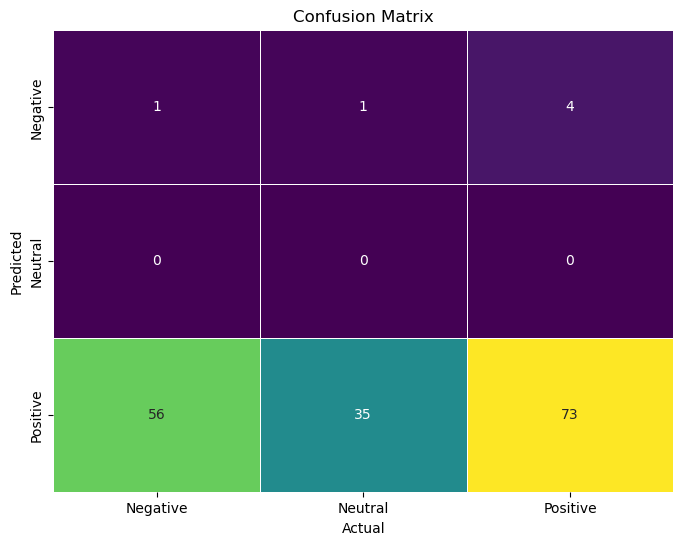

In [152]:
# another way to create a confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

# seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', linewidths=0.5, cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')

plt.show()

## Conclusion

As demonstrated by the initial matrix, the subsequent table, and the confusion matrix crafted with Seaborn, we can see that the performance of the Naive Bayes model appears to be relatively poor than training the record data. The model’s accuracy reached 43%, but it is important to know that it consistently predicted the positive label values. This outcome tells us that the naive bayes classifier used was too simplistic to accurately predict the sentiment of the Wikipedia articles.